In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

## Ⅰ. 수치 미분

$$
\frac{df(x)}{dx} = \lim_{h \rightarrow 0}{\frac{f(x+h)-f(x-h)}{2h}}
$$

In [2]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h)-f(x-h))/(2*h)

In [3]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return lambda t: d*t + y

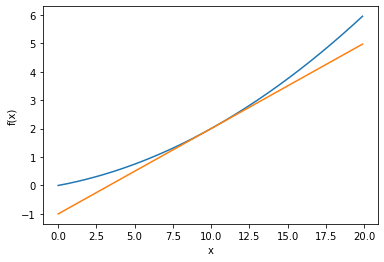

In [4]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

tf = tangent_line(function_1, 10)
y2 = tf(x)

plt.xlabel('x'); plt.ylabel('f(x)')
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

In [5]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=-1)

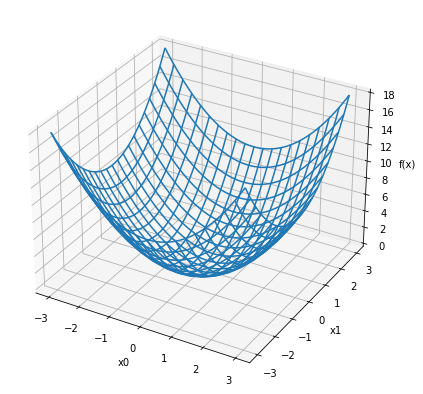

In [6]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(np.linspace(-3, 3, 61), np.linspace(-3, 3, 61))
Z = function_2(np.stack([X,Y], axis=-1))

ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('f(x)')
plt.show()

In [7]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

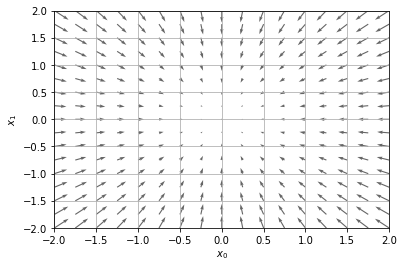

In [8]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.grid()
plt.show()

## Ⅱ. Gradient Descent

$$
\mathbf{W} = \mathbf{W} - \eta\frac{\partial L}{\partial \mathbf{W}}
$$
$\eta$  : learning rate

In [9]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
    
    return x

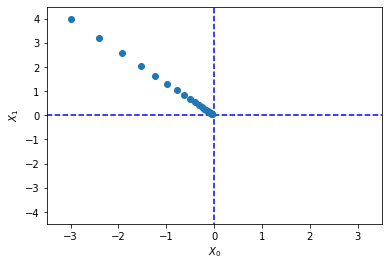

In [10]:
x = np.array([-3.0, 4.0])    
lr = 0.1
step_num = 20

history = [x.copy()]
for _ in range(step_num):
    x = gradient_descent(function_2, x, lr=lr, step_num=1)
    history.append(x.copy())

history = np.array(history)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(history[:,0], history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")
plt.show()

## Ⅲ. 신경망에서의 Gradient Descent

In [11]:
import sys, os
sys.path.append(os.pardir)
from modules.nn import softmax, sigmoid, CrossEntropyOneHotEncoded, LinearLayer

In [12]:
def numerical_gradient(f, w):

    h = 1e-4
    grad = np.zeros_like(w)

    for index, x in np.ndenumerate(w):
        
        w[index] = x + h
        fxh1 = f(w)

        w[index] = x - h
        fxh2 = f(w)

        grad[index] = (fxh1 - fxh2) / (2*h)
        w[index] = x

    return grad

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [13]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):

        W1 = weight_init_std * np.random.randn(input_size, hidden_size)
        b1 = np.zeros(hidden_size)
        W2 = weight_init_std * np.random.randn(hidden_size, output_size)
        b2 = np.zeros(output_size)
        
        self.layer1 = LinearLayer(W1, b1)
        self.layer2 = LinearLayer(W2, b2)
        
        self.params = {'W1':self.layer1.w, 'b1':self.layer1.b, 'W2':self.layer2.w, 'b2':self.layer2.b}
        
    def predict(self, x):
        output = sigmoid(self.layer1.forward(x))
        output = softmax(self.layer2.forward(output))
        return output

    def loss(self, x, t):
        y = self.predict(x)
        return CrossEntropyOneHotEncoded(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / x.shape[0]
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.layer1.w)
        grads['b1'] = numerical_gradient(loss_W, self.layer1.b)
        grads['W2'] = numerical_gradient(loss_W, self.layer2.w)
        grads['b2'] = numerical_gradient(loss_W, self.layer2.b)
        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [14]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = int(train_size / batch_size)

In [15]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for step in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if (step+1) % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("Step: {:04d}, Train Acc: {:.5f}, Test Acc: {:.5f}".format(step+1, train_acc, test_acc))

Step: 0600, Train Acc: 0.79268, Test Acc: 0.79490
Step: 1200, Train Acc: 0.87792, Test Acc: 0.88320
Step: 1800, Train Acc: 0.89697, Test Acc: 0.90150
Step: 2400, Train Acc: 0.90907, Test Acc: 0.91120
Step: 3000, Train Acc: 0.91448, Test Acc: 0.91700
Step: 3600, Train Acc: 0.92003, Test Acc: 0.92220
Step: 4200, Train Acc: 0.92428, Test Acc: 0.92580
Step: 4800, Train Acc: 0.92743, Test Acc: 0.92850
Step: 5400, Train Acc: 0.93155, Test Acc: 0.93260
Step: 6000, Train Acc: 0.93380, Test Acc: 0.93510
Step: 6600, Train Acc: 0.93702, Test Acc: 0.93640
Step: 7200, Train Acc: 0.93972, Test Acc: 0.93940
Step: 7800, Train Acc: 0.94135, Test Acc: 0.94170
Step: 8400, Train Acc: 0.94352, Test Acc: 0.94240
Step: 9000, Train Acc: 0.94528, Test Acc: 0.94410
Step: 9600, Train Acc: 0.94740, Test Acc: 0.94500


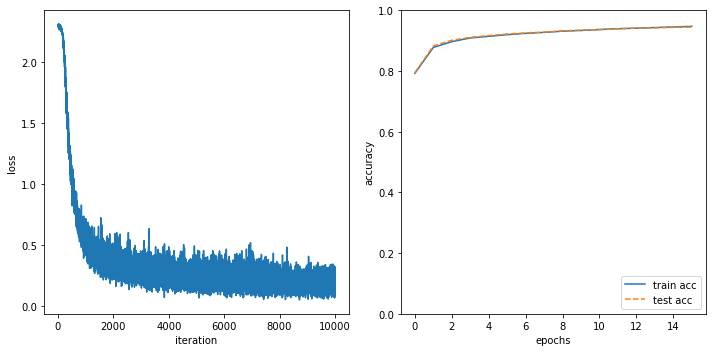

In [16]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

x_loss = np.arange(len(train_loss_list))
ax1.plot(x_loss, train_loss_list)
ax1.set_xlabel("iteration")
ax1.set_ylabel("loss")

x_acc = np.arange(len(train_acc_list))
ax2.plot(x_acc, train_acc_list, label='train acc')
ax2.plot(x_acc, test_acc_list, label='test acc', linestyle='--')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_ylim(0, 1.0)
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()